In [ ]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [4]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [5]:
#case_expected_score_dict

In [6]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

'df = event_df[event_df.攻撃チーム==team]\ntriple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))\nlst = make_flattened_list(triple)'

In [ ]:
def triple_on_score_diff(team, diff_lower, diff_upper):
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## negative facilitation = 負けてることが逆に力になる

## negative facilitaitonを起こしがちなチームは、僅差で負けているとdet時の期待得点が上がる

# 点数気にしない

In [7]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

レンジャーズ 0.959357641029 0.96651778918
オリオールズ 0.997117001178 0.955702491199
カージナルス 0.929605089763 0.886356896446
パイレーツ 0.893305279729 0.6288820725
フィリーズ 0.87676551924 0.779891375977
Wソックス 0.945604354354 0.878072903062
Rソックス 0.87492455598 0.815787214018
ロイヤルズ 1.03987290469 0.787326989454
タイガース 0.910618877114 0.712728549098
メッツ 0.873975654756 0.958449671134
エンゼルス 0.908445848475 0.944996109893
マーリンズ 0.936588342746 0.796156103172
ブリュワーズ 1.04429625014 0.941393604414
マリナーズ 0.939863564986 0.898330473234
ジャイアンツ 0.675578862939 0.652120478222
ブルージェイズ 0.941945206471 1.01492945163
ドジャース 0.930329051034 1.00855411789
レイズ 0.781894181733 0.912021654353
ツインズ 0.922416065842 0.838590258153
ナショナルズ 0.971800909134 0.810211018908
カブス 0.878238708199 0.872866513439
アスレチックス 1.07203822087 1.07874620108
パドレス 0.81069432596 0.892233666003
アストロズ 0.943700625491 0.913777437932
インディアンス 0.955432361261 1.01760316618
Dバックス 1.08847179011 0.897224473664
ロッキーズ 0.978668138338 0.923310517824
ヤンキース 1.093514823 0.998737690998
レッズ 0

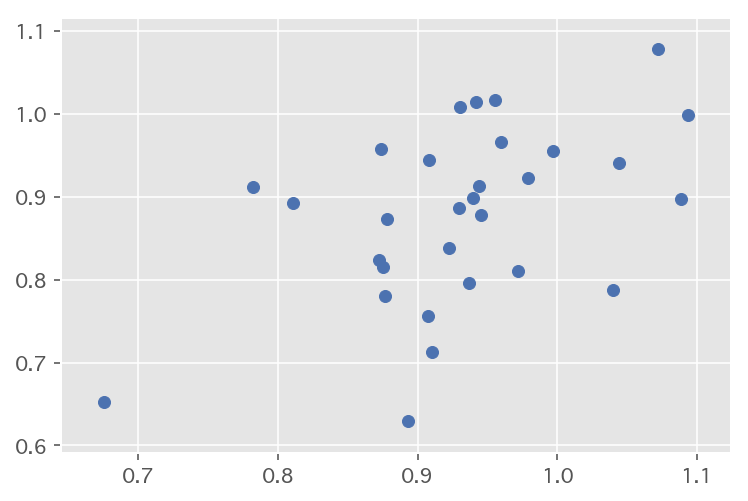

In [8]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# 4点差の負け以内

In [9]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, -4, -1)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

レンジャーズ 0.753994405357 0.909335097189
オリオールズ 0.94036231176 1.01664136382
カージナルス 0.837407177637 0.951409160654
パイレーツ 0.775855219325 0.550338518989
フィリーズ 0.77081731056 0.814196468973
Wソックス 0.892806647087 0.80975558244
Rソックス 0.897738689886 0.992423354302
ロイヤルズ 1.00792493414 0.989192688572
タイガース 0.724899468543 0.626144982665
メッツ 0.86903356121 0.933200979528
エンゼルス 0.878142795505 0.821077370057
マーリンズ 0.818221355847 0.806030445924
ブリュワーズ 0.961079552822 0.943721761449
マリナーズ 1.00658487561 0.755082732093
ジャイアンツ 0.759051648149 0.558853899568
ブルージェイズ 0.941586507098 0.903275673946
ドジャース 0.879738909063 1.03213344213
レイズ 0.622322520938 0.954402155355
ツインズ 0.900463453631 0.805591751238
ナショナルズ 0.618319418511 0.79587993336
カブス 0.807570142034 0.71443266354
アスレチックス 1.02785096888 0.902588316355
パドレス 0.83748518303 0.967402540718
アストロズ 0.74961492272 0.960403095222
インディアンス 0.869799276032 0.962940371429
Dバックス 0.936656147125 0.718388850625
ロッキーズ 0.940980588885 0.726660628152
ヤンキース 0.853900337424 0.798152212343
レ

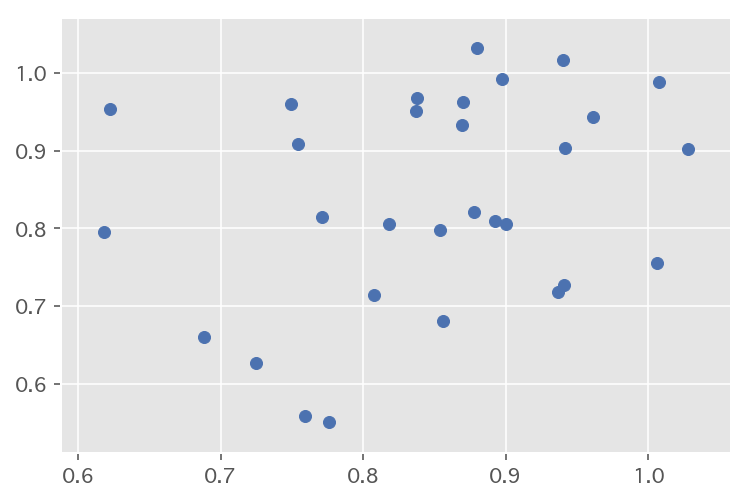

In [10]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [11]:
# 僅差で負けていると、流れが悪くても頑張るチーム
for team in teams_mlb:
    if res_dict1[team][1] < res_dict[team][1]:
        print(ranking(team), team, res_dict[team][1] - res_dict1[team][1])

5 オリオールズ 0.0609388726238
3 カージナルス 0.0650522642076
3 フィリーズ 0.0343050929966
1 Rソックス 0.176636140284
5 ロイヤルズ 0.201865699118
5 マーリンズ 0.00987434275224
1 ブリュワーズ 0.0023281570351
1 ドジャース 0.0235793242349
3 レイズ 0.042380501002
5 パドレス 0.0751688747159
1 アストロズ 0.0466256572896


In [12]:
# 僅差で負けていると、流れが悪いと諦めるチーム
for team in teams_mlb:
    if res_dict1[team][1] > res_dict[team][1]:
        print(ranking(team), team, res_dict[team][1] - res_dict1[team][1])

5 レンジャーズ -0.0571826919908
4 パイレーツ -0.0785435535115
4 Wソックス -0.0683173206228
3 タイガース -0.0865835664337
4 メッツ -0.0252486916058
4 エンゼルス -0.123918739836
3 マリナーズ -0.143247741141
4 ジャイアンツ -0.0932665786532
4 ブルージェイズ -0.111653777687
2 ツインズ -0.0329985069149
2 ナショナルズ -0.0143310855479
2 カブス -0.1584338499
2 アスレチックス -0.176157884728
1 インディアンス -0.0546627947491
3 Dバックス -0.178835623038
2 ロッキーズ -0.196649889672
2 ヤンキース -0.200585478654
5 レッズ -0.16406645106
1 ブレーブス -0.075988879418


In [ ]:
make_score_df_mlb("オリオールズ").得点.mean()

In [ ]:
make_score_df_mlb("Rソックス").得点.mean()

In [ ]:
for team in teams_mlb:
    print(team, make_score_df_mlb(team).得点.mean())